In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Regression, no CV, no HP tuning, no Scaling.
df = pd.read_csv("real_estate_PML.csv")
df = df.drop("type_l", axis = 1)
df.head()

,ville,arr,n_pieces,n_chambres,surface_m2,prix,prix_m2
0,Paris,17,3.0,1.0,51.84,535000.0,10320.0
1,Paris,15,3.0,2.0,40.77,470000.0,11528.0
2,Paris,13,2.0,1.0,39.00,385000.0,9871.0
3,Paris,13,2.0,1.0,36.03,383000.0,10630.0
4,Paris,10,2.0,1.0,40.70,399000.0,9803.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ville       5973 non-null   object 
 1   arr         5973 non-null   int64  
 2   n_pieces    5973 non-null   float64
 3   n_chambres  5973 non-null   float64
 4   surface_m2  5973 non-null   float64
 5   prix        5973 non-null   float64
 6   prix_m2     5973 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 326.8+ KB


In [37]:
# Features and target
features = [col for col in df.columns if col not in ['prix', 'prix_m2']]
y = df['prix']
X = df[features]
X = pd.get_dummies(X, dtype=float)
X.arr = X.arr.astype('float')

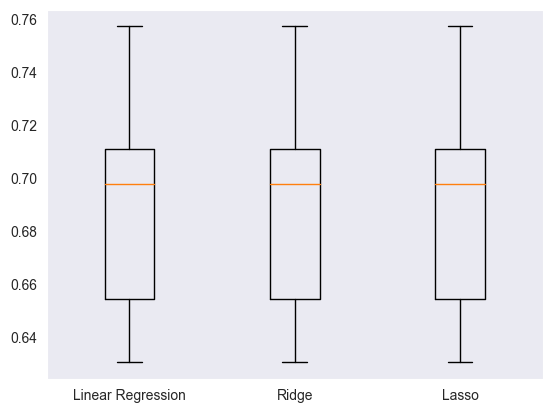

In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=25, test_size=0.15)
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha = 0.1), "Lasso": Lasso()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state = 4, shuffle=True)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_scores)

# Visualizing the best model
sns.set_style("dark")
plt.boxplot(results, labels=models.keys())
plt.show()

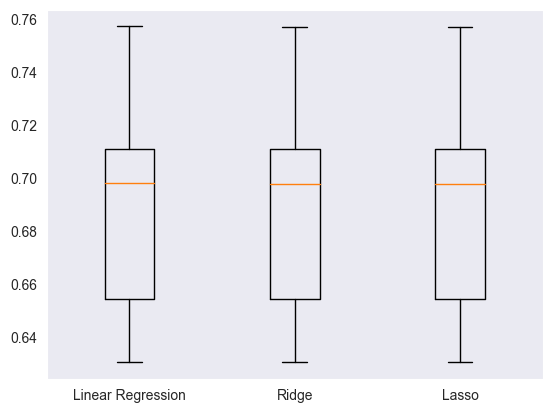

In [39]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
scaling_results = []

for model in models.values():
    kf = KFold(n_splits = 6, random_state = 4, shuffle = True)
    cv_scaled_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    scaling_results.append(cv_scaled_scores)

plt.boxplot(scaling_results, labels=models.keys())
plt.show()

In [40]:
# Hyperparameter tuning, CV and Scaling
kf = KFold(n_splits=6, random_state=5, shuffle=True)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('Ridge', Ridge())
])
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 50, 100]
solvers = ['svd', 'lsqr', 'cholesky']
parameters = [
    {'Ridge__alpha': alphas, 'Ridge__solver': solvers}
              ]
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=kf)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Best Hyperparameters: {'Ridge__alpha': 50, 'Ridge__solver': 'lsqr'}
Best Score: 0.684362425947724
RMSE: 333210.66084458097
